In [25]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from datetime import datetime

import pandarallel
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope

import scipy
from scipy import stats
from scipy.stats import gamma, lognorm

from patsy import dmatrices

import statsmodels.api as sm
from statsmodels.formula.api import glm
from statsmodels.graphics.api import abline_plot

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [26]:
pd.options.display.float_format = '{:,.2f}'.format

In [27]:
# load claims values df
claims_mat = pd.read_feather('data/rca_autoturisme_valEvMat.feather')

First, investigate the goodness of fit of the distribution of our data (WITH OUTLIERS), i.e. how closely it ressembles a gamma distribution. 

In [28]:
patsy_null = 'val_ron ~ 1'  # fitting the base model, no predictors just the target values
model_complete = glm(patsy_null, data = claims_mat[claims_mat.val_ron > 0], family = sm.families.Gamma(link=sm.families.links.log())).fit()
prediction = model_complete.predict(claims_mat[claims_mat.val_ron > 0])

temp = pd.DataFrame({'val_prd': prediction})
temp = pd.concat([claims_mat[claims_mat.val_ron > 0], temp], axis = 1)
model_complete.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                val_ron   No. Observations:               428235
Model:                            GLM   Df Residuals:                   428234
Model Family:                   Gamma   Df Model:                            0
Link Function:                    log   Scale:                          7.9033
Method:                          IRLS   Log-Likelihood:            -4.6050e+06
Date:                Thu, 24 Nov 2022   Deviance:                   5.3217e+05
Time:                        11:04:18   Pearson chi2:                 3.38e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              0.000
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.9015      0.004   2072.038      0.000       8.893       8.910
==============================================================================
"""

In [29]:
model_complete.aic

9210065.563162439

Method 1 Elliptic Envelop

In [30]:
data = claims_mat['val_ron'].array.reshape(-1, 1)
predictions = EllipticEnvelope().fit(data).predict(data)
claims_mat['ee_pred'] = predictions

In [31]:
print(f'Outlier mean: {claims_mat[claims_mat.ee_pred == -1].val_ron.mean()}')
print(f'Outlier min: {claims_mat[claims_mat.ee_pred == -1].val_ron.min()}')
print(f'Outlier max: {claims_mat[claims_mat.ee_pred == -1].val_ron.max()}')
print(f'Outlier total: {claims_mat[claims_mat.ee_pred == -1].val_ron.sum()}')

Outlier mean: 33945.22569753489
Outlier min: 15963.0
Outlier max: 8293198.960377693
Outlier total: 1453670345.271234


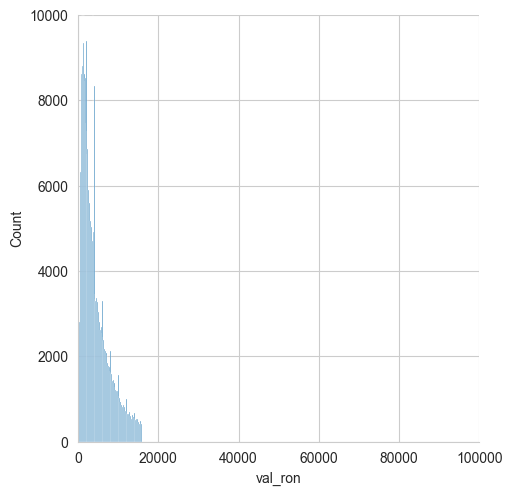

In [32]:
fig = sns.displot(claims_mat[claims_mat.ee_pred == 1], x = 'val_ron');
fig.set(xlim = (0, 100000))
fig.set(ylim = (0, 10000))

In [33]:
patsy_null = 'val_ron ~ 1'  # fitting the base model, no predictors just the target values
model_ee = glm(patsy_null, data = claims_mat[(claims_mat.val_ron > 0) & (claims_mat.ee_pred == 1)], family = sm.families.Gamma(link=sm.families.links.log())).fit()
prediction = model_ee.predict(claims_mat[(claims_mat.val_ron > 0) & (claims_mat.ee_pred == 1)])

temp = pd.DataFrame({'val_prd': prediction})
temp = pd.concat([claims_mat[(claims_mat.val_ron > 0) & (claims_mat.ee_pred == 1)], temp], axis = 1)
model_ee.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                val_ron   No. Observations:               385411
Model:                            GLM   Df Residuals:                   385410
Model Family:                   Gamma   Df Model:                            0
Link Function:                    log   Scale:                         0.62944
Method:                          IRLS   Log-Likelihood:            -3.5905e+06
Date:                Thu, 24 Nov 2022   Deviance:                   2.4937e+05
Time:                        11:04:23   Pearson chi2:                 2.43e+05
No. Iterations:                     7   Pseudo R-squ. (CS):              0.000
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.3864      0.001   6562.370      0.000       8.384       8.389
==============================================================================
"""

In [34]:
model_ee.aic

7181091.806767869

Method 2 Local outlier factor

In [35]:
data = claims_mat['val_ron'].array.reshape(-1, 1)
predictions = LocalOutlierFactor(n_neighbors=5, novelty=True).fit(data).predict(data)
claims_mat['lof_pred'] = predictions

In [36]:
patsy_null = 'val_ron ~ 1'  # fitting the base model, no predictors just the target values
model_lof = glm(patsy_null, data = claims_mat[(claims_mat.val_ron > 0) & (claims_mat.lof_pred == 1)], family = sm.families.Gamma(link=sm.families.links.log())).fit()
prediction = model_lof.predict(claims_mat[(claims_mat.val_ron > 0) & (claims_mat.lof_pred == 1)])

temp = pd.DataFrame({'val_prd': prediction})
temp = pd.concat([claims_mat[(claims_mat.val_ron > 0) & (claims_mat.lof_pred == 1)], temp], axis = 1)
model_lof.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                val_ron   No. Observations:               413049
Model:                            GLM   Df Residuals:                   413048
Model Family:                   Gamma   Df Model:                            0
Link Function:                    log   Scale:                          3.8793
Method:                          IRLS   Log-Likelihood:            -4.2473e+06
Date:                Thu, 24 Nov 2022   Deviance:                   5.1438e+05
Time:                        11:04:33   Pearson chi2:                 1.60e+06
No. Iterations:                     8   Pseudo R-squ. (CS):         -4.441e-15
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.8821      0.003   2898.298      0.000       8.876       8.888
==============================================================================
"""

In [37]:
model_lof.aic

8494664.781401433

Method 3 Isolation tree

In [38]:
random_state = np.random.RandomState(42)

# build IsolationForest model
model=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(0.01), random_state=random_state)
model.fit(claims_mat[['val_ron']])

# create a col with the results of the classification
claims_mat['iso_pred'] = model.predict(claims_mat[['val_ron']])

c:\Users\Cosmin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [39]:
patsy_null = 'val_ron ~ 1'  # fitting the base model, no predictors just the target values
model_iso = glm(patsy_null, data = claims_mat[(claims_mat.val_ron > 0) & (claims_mat.iso_pred == 1)], family = sm.families.Gamma(link=sm.families.links.log())).fit()
prediction = model_iso.predict(claims_mat[(claims_mat.val_ron > 0) & (claims_mat.iso_pred == 1)])

temp = pd.DataFrame({'val_prd': prediction})
temp = pd.concat([claims_mat[(claims_mat.val_ron > 0) & (claims_mat.iso_pred == 1)], temp], axis = 1)
model_iso.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                val_ron   No. Observations:               423971
Model:                            GLM   Df Residuals:                   423970
Model Family:                   Gamma   Df Model:                            0
Link Function:                    log   Scale:                          1.4423
Method:                          IRLS   Log-Likelihood:            -4.1620e+06
Date:                Thu, 24 Nov 2022   Deviance:                   4.3034e+05
Time:                        11:05:08   Pearson chi2:                 6.11e+05
No. Iterations:                     8   Pseudo R-squ. (CS):              0.000
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.7561      0.002   4747.395      0.000       8.752       8.760
==============================================================================
"""

In [40]:
model_iso.aic

8324049.077256074

All three together.

In [41]:
print(f'Number of outliers identified by elliptic envelope: {claims_mat[claims_mat.ee_pred == -1].shape[0]}')
print(f'Number of outliers identified by local outlier factor: {claims_mat[claims_mat.lof_pred == -1].shape[0]}')
print(f'Number of outliers identified by isolation tree: {claims_mat[claims_mat.iso_pred == -1].shape[0]}')
print('*'*50)
print(f'Number of outliers commonly identified by all three methods: {claims_mat[(claims_mat.ee_pred == -1) & (claims_mat.lof_pred == -1) & (claims_mat.iso_pred == -1)].shape[0]}')

Number of outliers identified by elliptic envelope: 42824
Number of outliers identified by local outlier factor: 15188
Number of outliers identified by isolation tree: 4264
**************************************************
Number of outliers commonly identified by all three methods: 92


In [42]:
42824+15188+4264

62276

In [43]:
df = claims_mat[(claims_mat.ee_pred == -1) & (claims_mat.lof_pred == -1) & (claims_mat.iso_pred == -1)].copy()
df.sample(5)

,idEvent,acc_year,idPolita,plati_ron,plati_eur,res_ron,res_eur,val_ron,val_eur,tip,ee_pred,lof_pred,iso_pred
293786,407902,2020,17610884,"83,930.00","17,044.22",0.00,0.00,"83,930.00","17,044.22",MAT,-1,-1,-1
242758,325117,2019,14832087,"26,789.00","5,413.98","37,487.91","7,642.95","64,276.91","13,056.92",MAT,-1,-1,-1
9504,9593,2015,2576595,"680,183.63","140,677.31","705,334.66","147,643.20","1,385,518.30","288,320.51",MAT,-1,-1,-1
60651,65294,2017,3805532,"83,460.00","18,319.88",0.00,0.00,"83,460.00","18,319.88",MAT,-1,-1,-1
122286,148416,2017,7928424,"64,356.00","13,819.49",0.00,0.00,"64,356.00","13,819.49",MAT,-1,-1,-1


In [44]:
patsy_null = 'val_ron ~ 1'  # fitting the base model, no predictors just the target values

df = claims_mat[claims_mat.val_ron > 0].copy()
df = df[~((df.ee_pred == -1) & (df.lof_pred == -1) & (df.iso_pred == -1))]

model_three = glm(patsy_null, data = df, family = sm.families.Gamma(link=sm.families.links.log())).fit()
prediction = model_three.predict(df)

temp = pd.DataFrame({'val_prd': prediction})
temp = pd.concat([df, temp], axis = 1)
model_three.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                val_ron   No. Observations:               428143
Model:                            GLM   Df Residuals:                   428142
Model Family:                   Gamma   Df Model:                            0
Link Function:                    log   Scale:                          3.7034
Method:                          IRLS   Log-Likelihood:            -4.3992e+06
Date:                Thu, 24 Nov 2022   Deviance:                   5.2491e+05
Time:                        11:05:11   Pearson chi2:                 1.59e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              0.000
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.8924      0.003   3023.539      0.000       8.887       8.898
==============================================================================
"""

In [45]:
model_three.aic

8798455.702319823

Outlier model comparison.

In [46]:
aics = [model_complete.aic, model_ee.aic, model_lof.aic, model_iso.aic, model_three.aic]
loglikes = [model_complete.llf, model_ee.llf, model_lof.llf, model_iso.llf, model_three.llf] 

model_df = pd.DataFrame([aics, loglikes], columns = ['complete', 'elliptic_env', 'local_outlier', 'iso_tree', 'all_three'], index =['aic', 'log-likelyhood'])
model_df.head()

,complete,elliptic_env,local_outlier,iso_tree,all_three
aic,"9,210,065.56","7,181,091.81","8,494,664.78","8,324,049.08","8,798,455.70"
log-likelyhood,"-4,605,031.78","-3,590,544.90","-4,247,331.39","-4,162,023.54","-4,399,226.85"


LOCAL OUTLIER FACTOR appears to have yielded the best results. I will now further investigate the outliers identified by this method.

In [47]:
# overview of the outliers identified
claims_mat[(claims_mat.val_ron > 0) & (claims_mat.lof_pred == -1)]['val_ron'].describe()

count      15,186.00
mean       11,165.85
std        80,798.38
min            10.00
25%         4,215.34
50%         7,783.57
75%        13,165.33
max     8,293,198.96
Name: val_ron, dtype: float64

Outliers on the small side have also been identified, but these are valid values and will not be removed.

In [48]:
# I will investigate the effects of removing outliers passed several thresholds on the aic score
thresholds = [2500000, 2000000, 1500000, 1000000, 500000, 100000, 50000, 15000]
aic = []
nr_drop = []

for thresh in thresholds:
    patsy_null = 'val_ron ~ 1' 
    temp = claims_mat[claims_mat.val_ron > 0].copy()
    temp.drop(claims_mat[(claims_mat.lof_pred == -1) & (claims_mat.val_ron > thresh)].index, axis = 0, inplace = True)

    model = glm(patsy_null, data = temp, family = sm.families.Gamma(link=sm.families.links.log())).fit()
    prediction = model.predict(temp)

    aic.append(model.aic)
    nr_drop.append(claims_mat[(claims_mat.lof_pred == -1) & (claims_mat.val_ron > thresh)].shape[0])

thresh_df = pd.DataFrame([aic, nr_drop], columns = ['2.5mil', '2mil', '1.5mil', '1mil', '500k', '100k', '50k', '15k'], index =['aic', 'nr_drop'])
thresh_df.head()


,2.5mil,2mil,1.5mil,1mil,500k,100k,50k,15k
aic,"8,862,463.53","8,832,611.17","8,832,611.17","8,803,924.37","8,803,924.37","8,800,646.44","8,797,282.92","8,748,448.62"
nr_drop,3.00,4.00,4.00,7.00,7.00,28.00,139.00,"2,573.00"


In [49]:
claims_mat[(claims_mat.val_ron > 0) & (claims_mat.lof_pred == -1)]['val_ron'].sort_values(ascending = False).head(10)

63074    8,293,198.96
237071   3,340,832.81
75281    2,532,157.30
777      2,436,672.48
22366    1,450,328.04
9504     1,385,518.30
80111    1,255,772.38
168162     334,354.00
85181      252,226.32
313777     251,579.00
Name: val_ron, dtype: float64

Big claims are those over 1 million RON. 

We will now remove all claims suggested by the LOF algorithm to be outliers.

In [57]:
# save lof outlier indices
lof_outlier_ind = np.array(claims_mat[(claims_mat.val_ron > 0) & (claims_mat.lof_pred == -1)].index)
np.save('data/autoturisme_mat_outliers_lof', lof_outlier_ind)